<a href="https://colab.research.google.com/github/sammyfow/cap-comp215/blob/2024.01/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1
Name: Sam Fowler

Start Date: 02/05/2024

End Date:

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque as dq
from timeit import timeit

# Genrating Ring Lattice Graphs

The cell below contains all the code for generating a ring lattice graph. A ring lattice is a connected graph in which all nodes have the same number of neighbours.

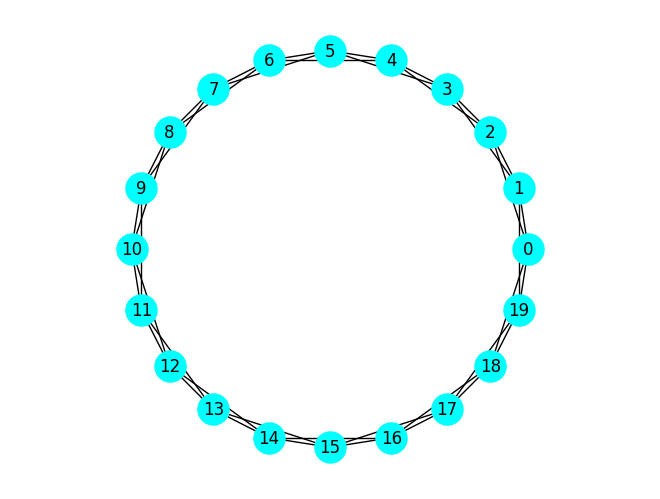

In [51]:

def better_pairs(nodes):
  for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
      if i > j:
        yield u, v


def make_complete_graph(n):
  points = range(n)
  graph = nx.Graph()
  graph.add_nodes_from(points)
  graph.add_edges_from(better_pairs(points))
  return graph


def adjecent_edges(n, k):
  nodes = range(n)
  for i in nodes:
    for j in range(k // 2):
      yield i, (i + j + 1) % n


def make_ring_lattice(n, k):
  g = nx.Graph()
  nodes = range(n)
  g.add_nodes_from(nodes)
  g.add_edges_from(adjecent_edges(n, k))
  return g


def draw_ring_lattice(n, k):
  nx.draw_circular(make_ring_lattice(n, k),
                   node_color='cyan',
                   node_size=500,
                   with_labels=True)
  plt.axis('equal')
  plt.show()


"""Enter some parameters to see what a ring lattice looks like"""
Nodes = 20
Neighbours = 5
draw_ring_lattice(Nodes, Neighbours)




# Creating Watts-Strogatz Graphs

A Watts-Strogatz graph starts with a ring lattice then each edge has a probability of being 'rewired' to a different randomly selected node.  

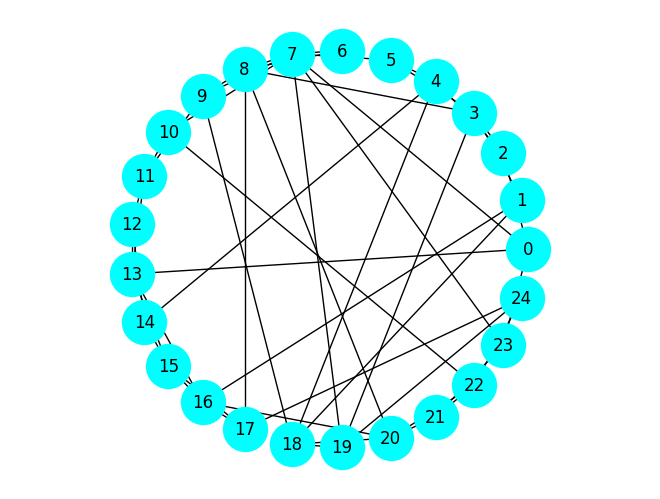

In [52]:
def rewire(g, p):
  nodes = set(g)
  for a, b in g.edges():
    if np.random.random() < p:
      choices = nodes - {a} - set(g[a])
      new_b = np.random.choice(list(choices))
      g.remove_edge(a, b)
      g.add_edge(a, new_b)
  return g


def make_ws_graph(n, k, p):
  ws = rewire(make_ring_lattice(n, k), p)
  return ws


def draw_ws_graph(n, k, p):
  nx.draw_circular(make_ws_graph(n, k, p),
                 node_color='cyan',
                 node_size=1000,
                 with_labels=True)
  plt.axis('equal')
  plt.show()

"""Enter some parameters to see what a WS graph looks like"""
Nodes = 25
Neighbours = 4
Probability = 0.5
draw_ws_graph(Nodes, Neighbours, Probability)





# Performing the Watts-Strogatz Experiment

The experiment is an analysis the average path length between nodes 'L', and the overall cliqueishness 'C' of WS graphs. We want to know how L and C change for a range of rewiring probabilities.

In [53]:
def node_clustering(G, node):
  neighbours = list(G[node])
  k = len(neighbours)
  if k < 2:
    return np.nan
  possible = k * (k - 1) / 2
  edges = 0
  for a, b in better_pairs(neighbours):
    if G.has_edge(a, b):
      edges +=1
  return edges / possible


def clustering_coefficient(G):
  cluster = [node_clustering(G, node) for node in list(G)]
  return np.nanmean(cluster)



def shortest_path_dijkstra(g, source):
  dist = {source: 0}
  queue = dq([source])
  while queue:
    node  = queue.popleft()
    new_dist = dist[node] + 1
    neighbours = set(g[node]).difference(dist)
    for n in neighbours:
      dist[n] = new_dist
    queue.extend(neighbours)
  return dist


def mean_dijkstra(g):
  lengths = []
  seen = set()
  for node in g.nodes():
    seen.add(node)
    dists = shortest_path_dijkstra(g, node)
    for i in dists:
      if i not in seen:
        lengths.append(dists[i])
  return np.mean(lengths)


def run_single_graph(n, k, p):
  ws = make_ws_graph(n, k, p)
  cc = clustering_coefficient(ws)
  msp = mean_dijkstra(ws)
  return cc, msp


ps = np.logspace(-5, 0, 10)
def run_experiment(n, k, iters):
  results = []
  for p in ps:
    trials = [run_single_graph(n, k, p) for t in range(iters)]
    means = np.array(trials).mean(axis=0)
    results.append(means)
  return np.array(results)






# Timing the Experiment

Below we can see how the time to run the experiment changes as the number of nodes increases

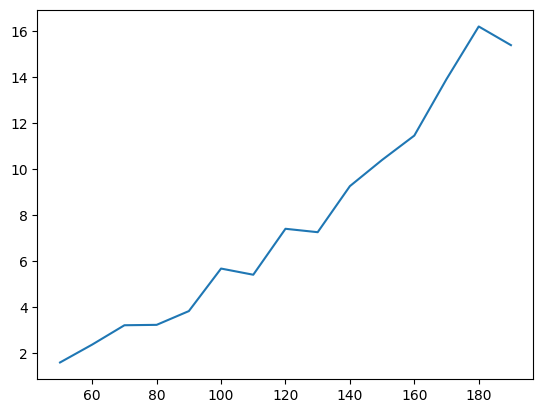

In [56]:
def time_exp(lower, upper):
  nodes = range(lower, upper, 10)
  timings = [timeit(lambda: run_experiment(node, k=20, iters=1), number=10) for node in nodes]
  plt.plot(nodes, timings)


"""Enter an upper and lower bound for the number of nodes"""
Minimum = 50
Maximum = 200
time_exp(Minimum, Maximum)







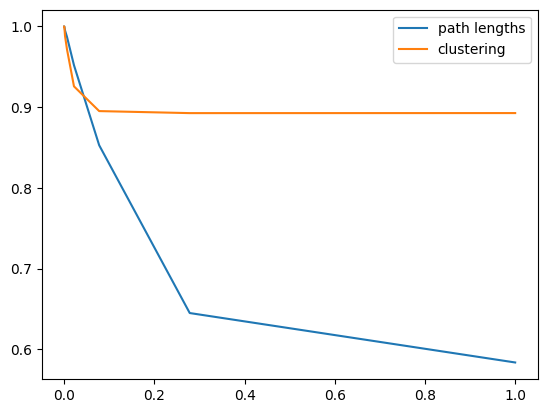

In [55]:
exp = run_experiment(100, 40, 20)
L, C = np.transpose(exp)
L /= L[0]
C /= C[0]


plt.plot(ps, L, label='path lengths')
plt.plot(ps, C, label='clustering')
plt.legend()
plt.show()